# Table of contents
1. [Library settings](#1-bullet)
2. [Data Processing](#2-bullet)
3. [ARIMA Model Training and Evaluation](#3-bullet)



## 1. [Library settings](#1-bullet)
Importing all necessary libraries for data processing, visualization, and ARIMA model building and evaluation.

In [7]:
import numpy as np

from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

import pandas as pd
import matplotlib.pyplot as plt
import math


## 2. [Data Processing](#2-bullet)

Load and process the dataset. This includes reading the data from a CSV file, converting the timestamp, setting the index, and visualizing the data.


In [8]:

# Load data
filepath = 'E:\\C\\ICT\\Machine Learning and Data Mining\\ML-DM-Stock-Price-Prediction\\Dataset\\VCB.csv'

df = pd.read_csv(filepath)
df['time'] = pd.to_datetime(df['time'], format='%m/%d/%Y')
df.set_index('time', inplace=True)
close = df[['close']]
close.head(10)

,close
time,
2016-01-04,19530
2016-01-05,19220
2016-01-06,19440
2016-01-07,19220
2016-01-08,19080
2016-01-11,18950
2016-01-12,19310
2016-01-13,19130
2016-01-14,18900


Visualizing the close price data to understand the trend and patterns.

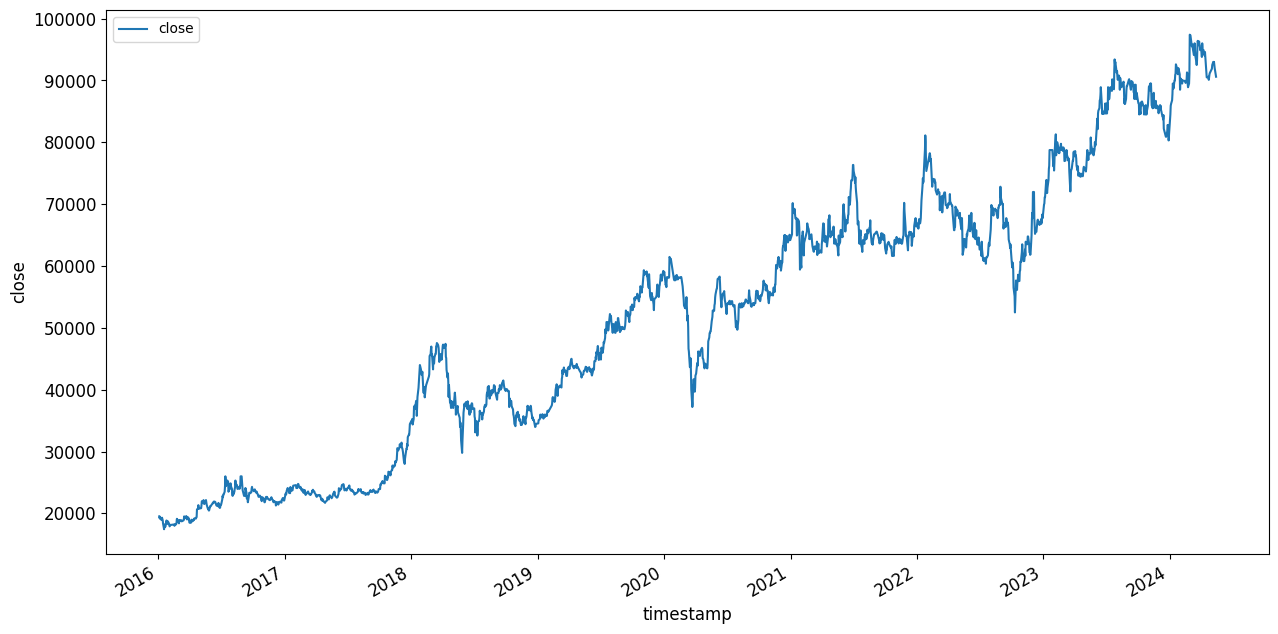

In [9]:
# Plot data
close.plot(y='close', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('close', fontsize=12)
plt.show()

Visualizing a subset of the data for more detailed inspection.

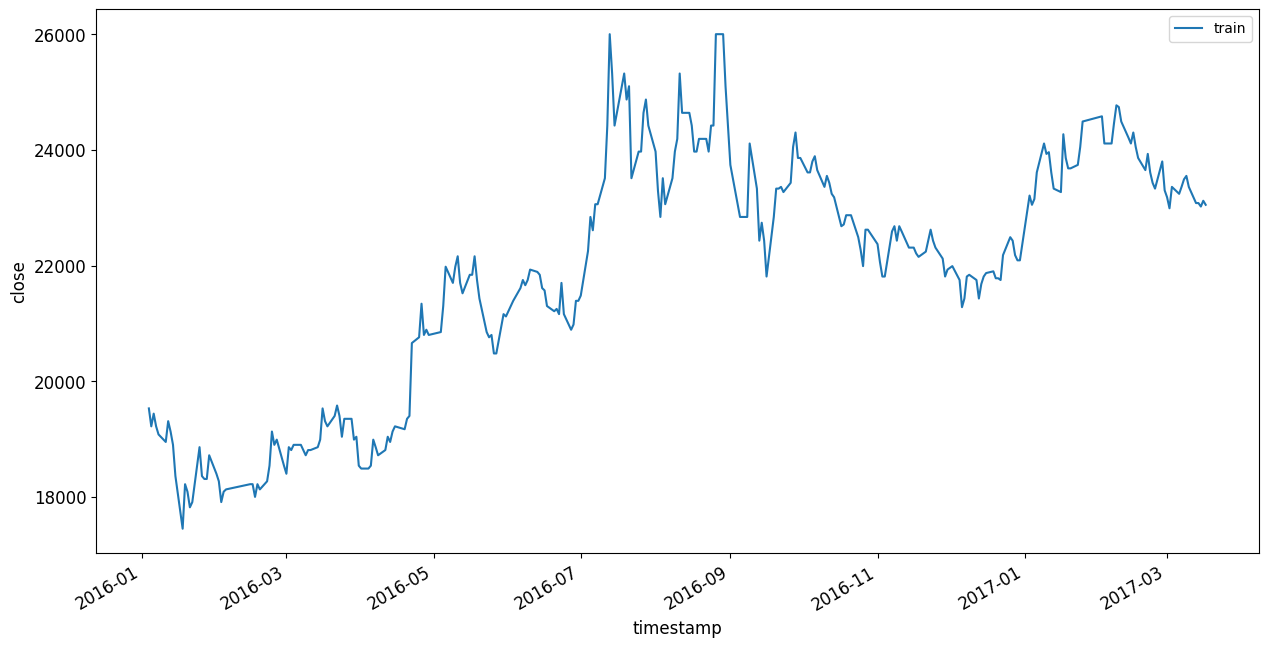

In [10]:
# Load 300 data
close[:300][['close']].rename(columns={'close': 'train'}) \
    .plot(y=['train'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('close', fontsize=12)
plt.show()

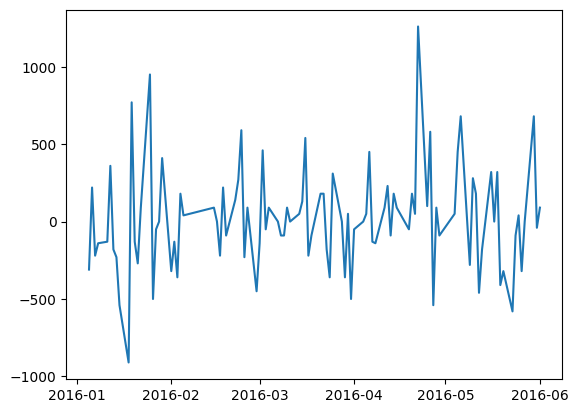

In [11]:
# Plot differences
plt.plot(close[:100].diff())

Splitting the dataset into training and test sets. Here, 70% of the data is used for training and the remaining 30% for testing.

In [12]:

# Split data
n = int(len(df) * 0.7)
m = int(len(df) * 0.7)

df_train = close.copy()[:n][['close']]
df_test = close.copy()[m:][['close']]

print('Training data shape: ', df_train.shape)
print('Test data shape: ', df_test.shape)

Training data shape:  (1460, 1)
Test data shape:  (627, 1)


Plotting the autocorrelation and partial autocorrelation of the training data to identify the order of the ARIMA model.

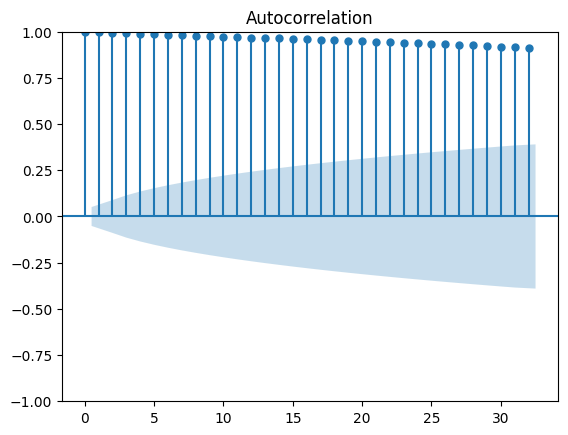

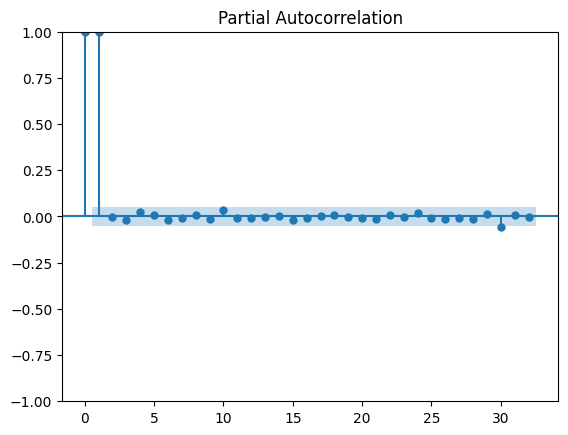

In [13]:

plot_acf(df_train['close'])
plot_pacf(df_train['close'])
plt.show()


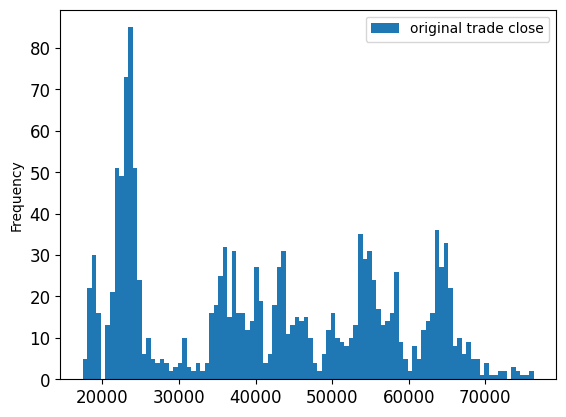

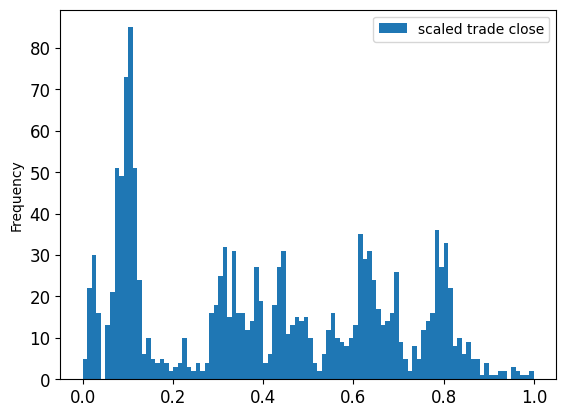

,close
time,
2021-11-05,0.788929
2021-11-08,0.796893
2021-11-09,0.784513
2021-11-10,0.790117
2021-11-11,0.797928


In [14]:
# Scale train
scaler = MinMaxScaler()
df_train['close'] = scaler.fit_transform(df_train)

close[:n][['close']].rename(columns={'close': 'original trade close'}).plot.hist(bins=100, fontsize=12)
df_train.rename(columns={'close': 'scaled trade close'}).plot.hist(bins=100, fontsize=12)
plt.show()

# Scale test
df_test['close'] = scaler.transform(df_test)
df_test.head()


In [15]:

# Specify the number of steps to forecast ahead
HORIZON = 6
print('Forecasting horizon:', HORIZON, 'days')

df_test_shifted = df_test.copy()
for t in range(1, HORIZON):
    df_test_shifted['close+' + str(t)] = df_test_shifted['close'].shift(-t)
df_test_shifted = df_test_shifted.dropna(how='any')
df_test_shifted.head(5)

# Fit ARIMA model
order = (1, 1, 1)
model = ARIMA(df_train, order=order)
results = model.fit()

print(results.summary())

Forecasting horizon: 6 days
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1460
Model:                 ARIMA(1, 1, 1)   Log Likelihood                4181.246
Date:                Fri, 31 May 2024   AIC                          -8356.492
Time:                        22:26:34   BIC                          -8340.635
Sample:                             0   HQIC                         -8350.576
                               - 1460                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0054      1.761     -0.003      0.998      -3.456       3.446
ma.L1         -0.0055      1.761     -0.003      0.998      -3.456       3.445
sigma2         0.0002   

## 3. [ARIMA Model Training and Evaluation](#3-bullet)

### Check Stationarity and Dickey-Fuller test

In [27]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(ts_data):
    roll_mean = ts_data.rolling(30, center=True, closed='both').mean()
    roll_std = ts_data.rolling(5, center=True, closed='both').std()
    
    fig = plt.figure(figsize=(20,10))
    plt.subplot(211)
    plt.plot(ts_data, color='black', label='Original Data')
    plt.plot(roll_mean, color='red', label='Rolling Mean(30 days)')
    plt.legend()
    plt.subplot(212)
    plt.plot(roll_std, color='green', label='Rolling Std Dev(5 days)')
    plt.legend()
    
    # Dickey-Fuller test
    print('Dickey-Fuller test results\n')
    df_test = adfuller(ts_data, regresults=False)
    test_result = pd.Series(df_test[0:4], index=['Test Statistic','p-value','# of lags','# of obs'])
    print(test_result)
    for k,v in df_test[4].items():
        print('Critical value at %s: %1.5f' %(k,v))

In [36]:

df_final = pd.Series(df['close'])


Dickey-Fuller test results

Test Statistic      -0.680998
p-value              0.851610
# of lags            3.000000
# of obs          2083.000000
dtype: float64
Critical value at 1%: -3.43349
Critical value at 5%: -2.86293
Critical value at 10%: -2.56751


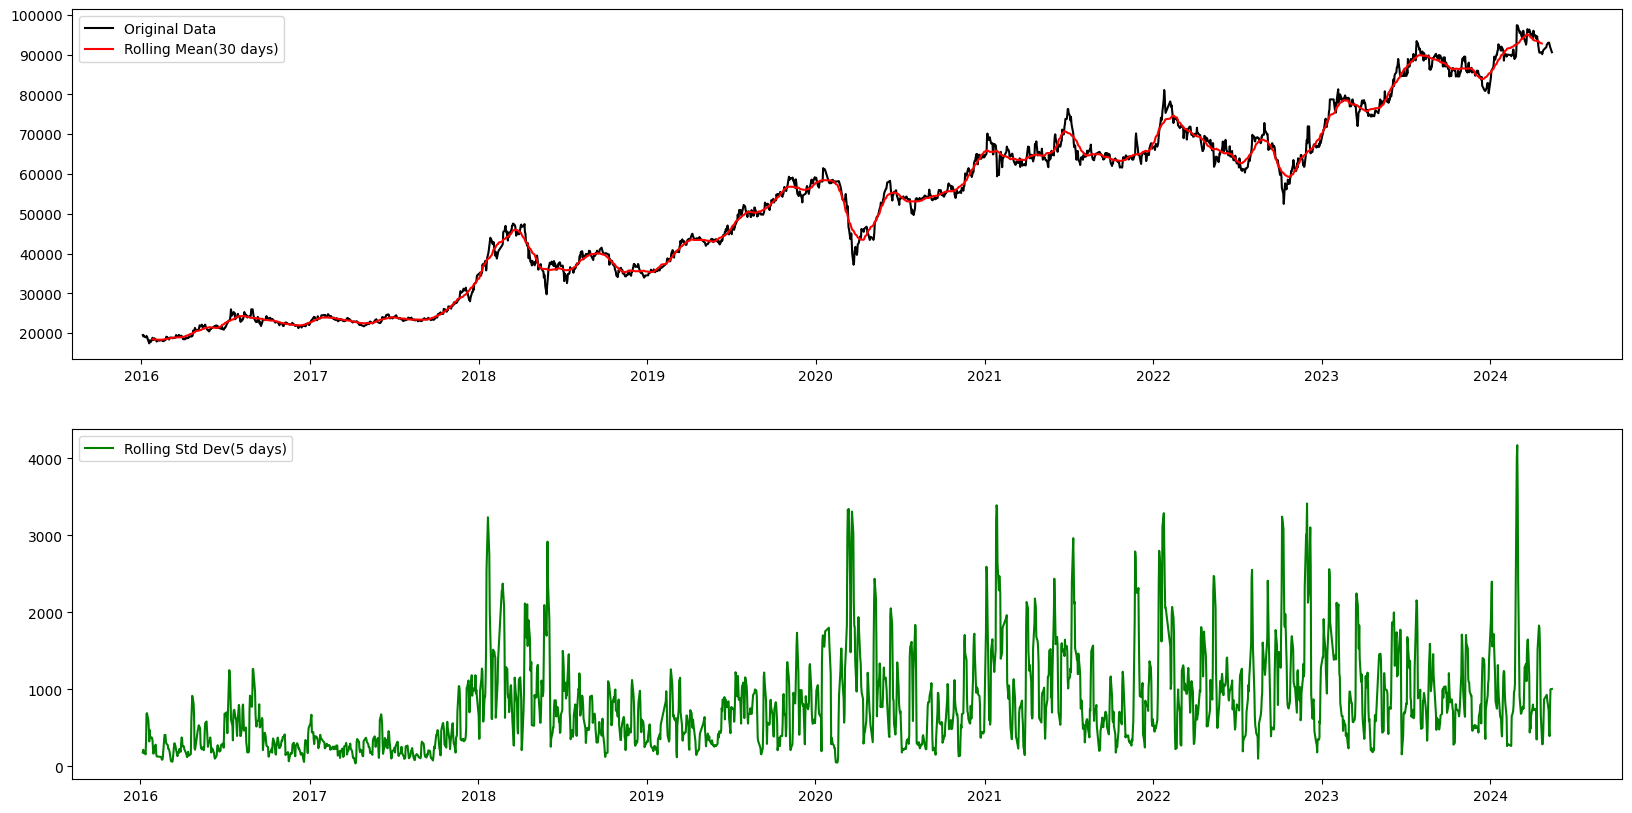

In [37]:
check_stationarity(df_final)

In [38]:
df_final_diff = df_final - df_final.shift()

Dickey-Fuller test results

Test Statistic     -27.87779
p-value              0.00000
# of lags            2.00000
# of obs          2083.00000
dtype: float64
Critical value at 1%: -3.43349
Critical value at 5%: -2.86293
Critical value at 10%: -2.56751


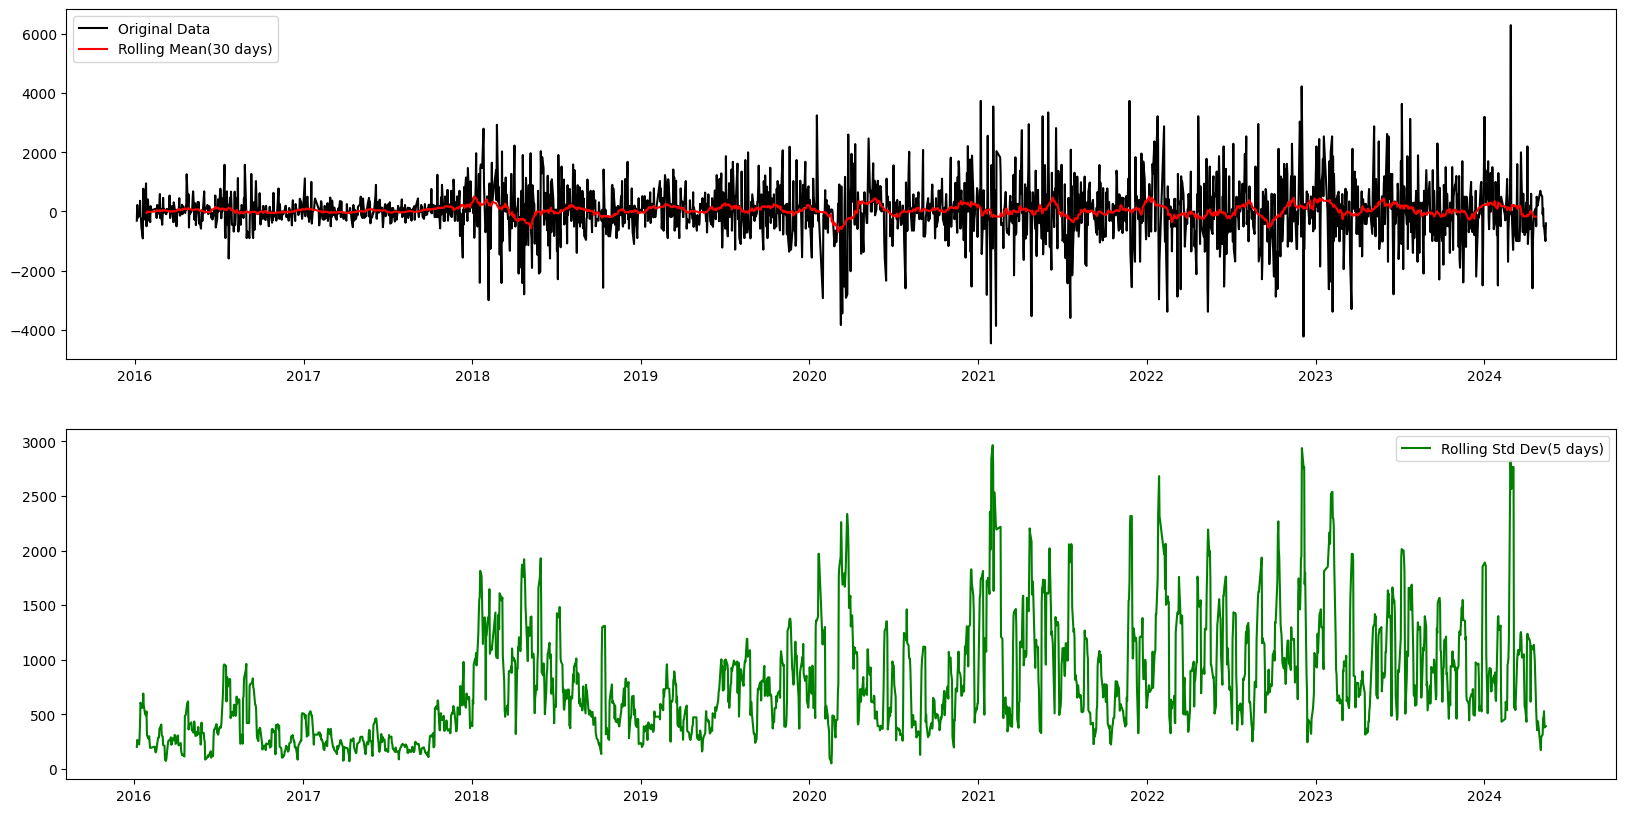

In [39]:
df_final_diff.dropna(inplace=True)
check_stationarity(df_final_diff)

### Training and evaluation

In [ ]:

# Evaluate model
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(df_train[['close']])
test_scaled = scaler.transform(df_test_shifted[['close']])

train_ts = pd.Series(train_scaled.flatten(), index=df_train.index)
test_ts = pd.Series(test_scaled.flatten(), index=df_test_shifted.index)

p = d = q = range(0, 3)
best_aic = np.inf
best_order = None

for p_val in p:
    for d_val in d:
        for q_val in q:
            try:
                model = ARIMA(train_ts, order=(p_val, d_val, q_val))
                model_fit = model.fit()
                aic = model_fit.aic
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p_val, d_val, q_val)
            except:
                continue

print(f'Best ARIMA parameters: {best_order} with AIC: {best_aic}')

In [ ]:

# Train and test ARIMA with the best parameters
training_window = 30  # dedicate 30 days for training

train_ts = df_train['close']
test_ts = df_test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = []

order = best_order  # update with best (p,d,q)

for i in range(test_ts.shape[0]):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    output = model_fit.forecast(steps=HORIZON)
    predictions.append(output)
    obs = list(test_ts.iloc[i])
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[i])
    print(i + 1, ': predicted =', output, 'expected =', obs)

### Compare predictions to actual load

In [55]:
training_window= 30 # dedicate 30 days for training

train_ts=df_train['close']
test_ts=df_test_shifted

In [56]:
train_test = np.array(train_ts)
test_set = np.array(test_ts)
pred = np.array(predictions)

# Đảm bảo các mảng là 2D bằng cách sử dụng reshape
pred = scaler.inverse_transform(pred.reshape(-1, 1))
test_set = scaler.inverse_transform(test_set.reshape(-1, 1))

In [57]:
print(test_set.shape)
print(pred.shape)

(3732, 1)
(3732, 1)


In [83]:
# evaluate forecasts
mae = mean_absolute_error(test_set, pred)
rmse = np.sqrt(mean_squared_error(test_set, pred))
r2_test = r2_score(test_set, pred)
print('Mean Absolute Error (MAE): %.4f' % mae)
print('Test RMSE: %.4f' % rmse)
print('Test r2_score: %.4f' % r2_test)

Mean Absolute Error (MAE): 0.0284
Test RMSE: 0.0389
Test r2_score: 0.9554


In [ ]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = df_test.index[0:len(df_test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

In [60]:
if(HORIZON > 1):
    eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
    print(eval_df.groupby('h')['APE'].mean())

h
t+1    0.017039
t+2    0.024082
t+3    0.028721
t+4    0.032335
t+5    0.036026
t+6    0.039341
Name: APE, dtype: float64


In [61]:
def mape(predictions, actuals):
    """Mean absolute percentage error"""
    return ((predictions - actuals).abs() / actuals).mean()

In [62]:
print('One step forecast MAPE: ', (mape(eval_df[eval_df['h'] == 't+1']['prediction'], eval_df[eval_df['h'] == 't+1']['actual']))*100, '%')

One step forecast MAPE:  1.7039306400449823 %


In [63]:
print('Multi-step forecast MAPE: ', mape(eval_df['prediction'], eval_df['actual'])*100, '%')

Multi-step forecast MAPE:  2.95907098692811 %


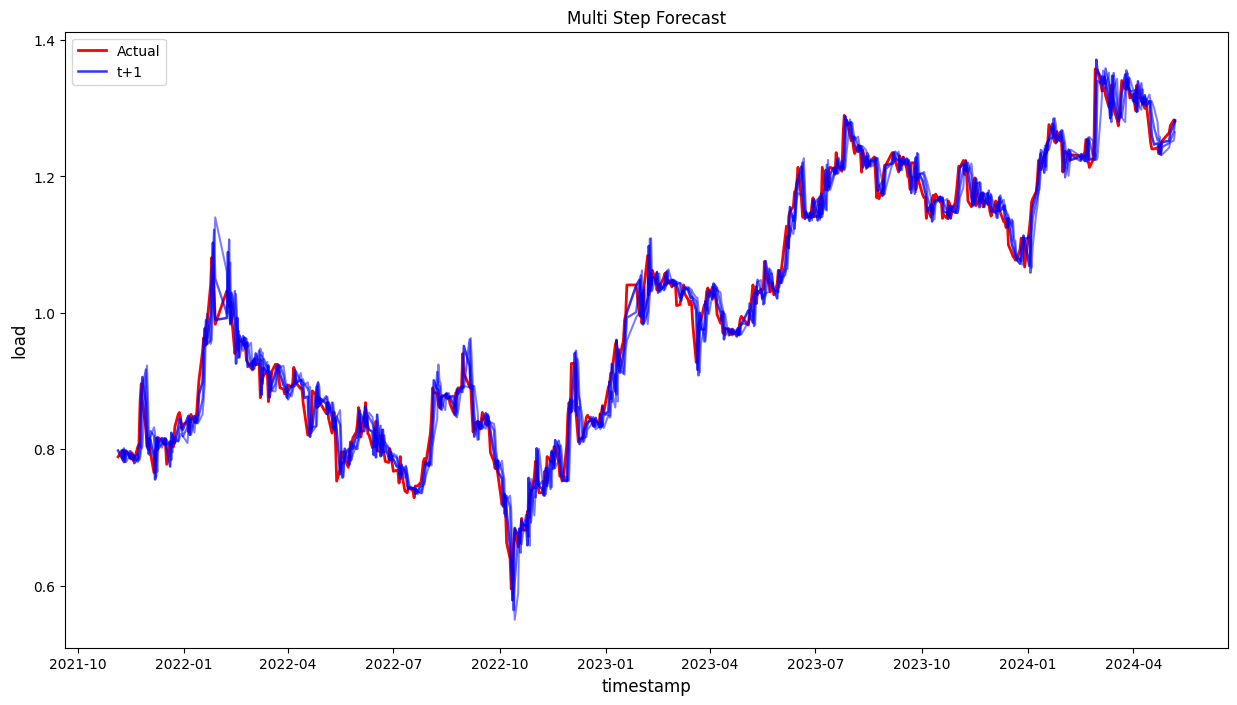

In [64]:
HORIZON = 3
if(HORIZON == 1):
    ## Plotting single step forecast
    eval_df.plot(x='timestamp', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))
    plt.xlabel('timestamp', fontsize=12)
    plt.ylabel('load', fontsize=12)
    plt.title('Single Step Forecast')
    plt.legend(['Actual', 'Prediction'])
    plt.show()

else:
    ## Plotting multi step forecast
    plot_df = eval_df[eval_df.h == 't+1'][['timestamp', 'actual']].copy()
    for t in range(1, HORIZON + 1):
        plot_df['t+' + str(t)] = eval_df[eval_df.h == 't+' + str(t)]['prediction'].values

    plt.figure(figsize=(15, 8))
    plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=2.0, label='Actual')

    for t in range(1, HORIZON + 1):
        x = plot_df['timestamp'][(t - 1):]
        y = plot_df['t+' + str(t)][0:len(x)]
        plt.plot(x, y, color='blue', linewidth=2 * math.pow(.9, t), alpha=math.pow(0.8, t), label=f't+{t}' if t == 1 else "")

    plt.xlabel('timestamp', fontsize=12)
    plt.ylabel('load', fontsize=12)
    plt.title('Multi Step Forecast')
    plt.legend(loc='best')
    plt.show()